In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from utils import compute_divergence_field
from models import HelmholtzResNN
# from models import HelmholtzNN

device = "cuda" if torch.cuda.is_available() else "cpu"

# RETRAIN = False
RETRAIN = True

In [3]:
data = torch.load("/home/kim/ice_shelves_flux_decomposition/data/flux_train_tensor.pt", 
                   weights_only = False)

# We are splitting and training only on train onl to monitor generalisation performace. We shall retrain on all data.

In [4]:
### Make torch.dataset ###
# takes two separate tensors as input
dataset = TensorDataset(data[:, :2], data[:, 2:])

# Inspect
# Shape of (first) X sample
print(dataset[0][0].shape)
# Shape of (first) Y sample
print(dataset[0][1].shape)

### Define sizes n observations for splits ###
train_size = int(0.7 * dataset.__len__())
test_size = dataset.__len__() - train_size
print(f"Train size: {train_size}, Test size: {test_size}")

### Random split ###
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

### Create DataLoaders ###
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1024, shuffle = False)
all_loader = DataLoader(dataset, batch_size = 1024, shuffle = True)

torch.Size([2])
torch.Size([2])
Train size: 2245662, Test size: 962427


# Loop (Training only)

In [5]:
# ----- Training loop -----
if RETRAIN:
    model = HelmholtzResNN().to(device)
    # 5e-3 was a bit jittery
    optim = torch.optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-7)
    loss_function = nn.MSELoss()

    # epochs = 10
    epochs = 10
    # print every N batches
    # print_every = 500

    train_losses = []
    test_losses  = []

    for ep in range(1, epochs + 1):
        # ------------------ TRAIN ------------------
        model.train()
        train_loss_sum = 0.0
        
        # NOTE: Train on ALL data (no split)
        for i, (X_batch, Y_batch) in enumerate(all_loader):
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            optim.zero_grad(set_to_none = True)
            Y_hat = model(X_batch)
            loss = loss_function(Y_hat, Y_batch)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

            train_loss_sum += loss.item() * X_batch.size(0)

        epoch_avg_train_loss = train_loss_sum / len(train_loader.dataset)

        # store for plotting later
        train_losses.append(epoch_avg_train_loss)

        # Print every epoch: ~ 2 min per epoch
        # ~14 min for 10 epochs on GPU
        print(f"[epoch {ep:03d}] train_loss = {epoch_avg_train_loss:.6f}")

    # ------------------ SAVE ------------------
    torch.save(model.state_dict(), "trained_model/helmholtz_resnn_all_data.pth")
    pd.DataFrame({'train_loss': train_losses}).to_csv("trained_model/helmholtz_resnn_loss.csv", index = False)

KeyboardInterrupt: 

# Visualise convergence

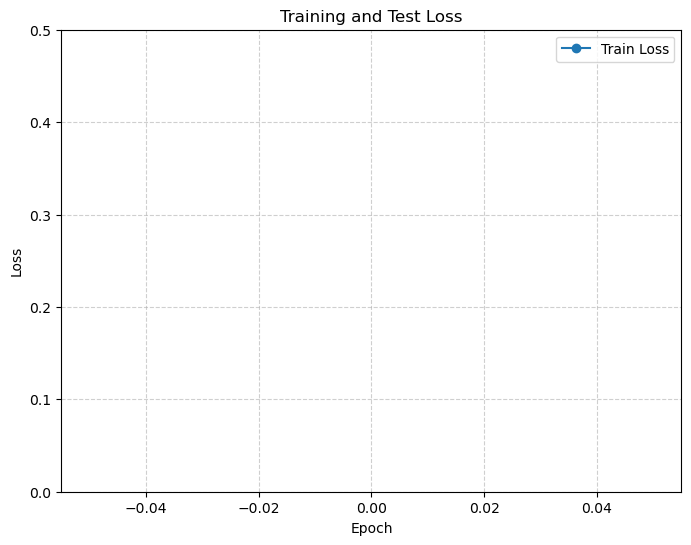

In [6]:
if RETRAIN:
    # Assume you already have train_losses and test_losses lists
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize = (8, 6))
    plt.plot(epochs, train_losses, label = "Train Loss", marker = "o")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    plt.grid(True, linestyle = "--", alpha = 0.6)
    plt.ylim(0, 0.5)
    plt.show()

# Or load

In [7]:
model = HelmholtzResNN().to(device)
model.load_state_dict(torch.load("trained_model/helmholtz_resnn_all_data.pth", map_location = device))
model.eval()

HelmholtzResNN(
  (inp): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU()
  )
  (trunk): ModuleList(
    (0-5): 6 x _ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (act): SiLU()
    )
  )
  (head_df_psi): Linear(in_features=256, out_features=1, bias=True)
  (head_cf_phi): Linear(in_features=256, out_features=1, bias=True)
)

# Check errors (on training data)

In [8]:
# All data is a bit dense (and memory intensive), so we spatially subsample
def spatial_subsample(data, n_cells = 100):
    x, y = data[:, 0], data[:, 1]

    # Compute integer cell indices
    ix = torch.clamp((x * n_cells).long(), max = n_cells - 1)
    iy = torch.clamp((y * n_cells).long(), max = n_cells - 1)
    cell_ids = ix * n_cells + iy   # [N]

    # Shuffle indices to randomize
    perm = torch.randperm(data.shape[0])
    cell_ids_perm = cell_ids[perm]

    # Get inverse mapping: which unique id each entry belongs to
    unique_ids, inv = torch.unique(cell_ids_perm, return_inverse = True)

    # First index per unique id = argmin within each group
    # Build a large index tensor and take the min
    arange = torch.arange(len(cell_ids_perm), device = data.device)
    first_idx = torch.full((len(unique_ids),), len(cell_ids_perm), device = data.device)

    first_idx = first_idx.scatter_reduce(0, inv, arange, reduce = "amin", include_self = True)

    # Map back to permuted indices
    chosen = perm[first_idx]

    return data[chosen]

# 11 k e.g
subset = spatial_subsample(data, n_cells = 200)
print(subset.shape)

torch.Size([11252, 4])


In [9]:
subset_x = subset[:, :2].to(device)
subset_y = subset[:, 2:].to(device)

prediction = model(subset_x.requires_grad_(True))

div_field = compute_divergence_field(
    mean_pred = prediction, 
    x_grad = subset_x)

rmse_field = torch.sqrt(torch.mean((prediction - subset_y) ** 2, dim = 1))
me_field = torch.mean((prediction - subset_y), dim = 1)
me_field.mean()

tensor(-0.0042, device='cuda:0', grad_fn=<MeanBackward0>)

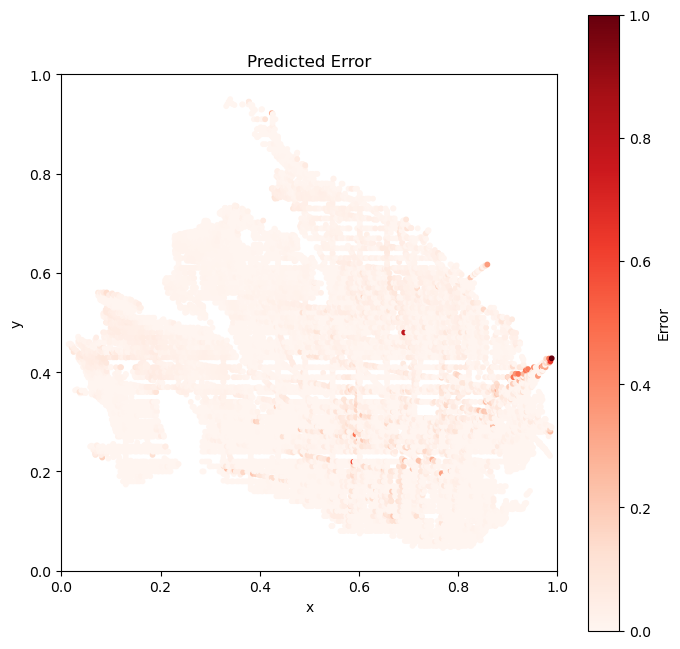

In [10]:
plt.figure(figsize = (8, 8))
plt.scatter(
    subset_x[:, 0].cpu().detach().numpy(), 
    subset_x[:, 1].cpu().detach().numpy(),
    c = me_field.cpu().detach().numpy(), 
    cmap = "Reds", 
    vmin = 0, vmax = 1,
    s = 10)
plt.colorbar(label = "Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Error")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.gca().set_aspect("equal")
plt.show()

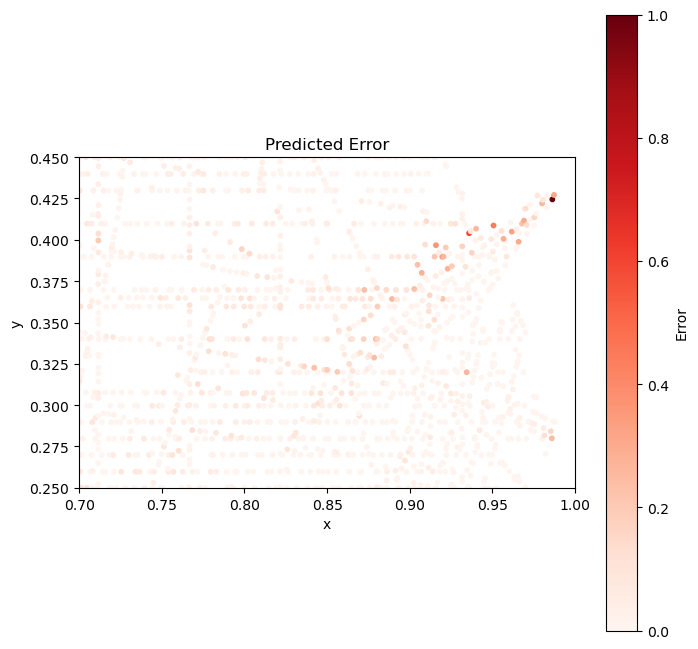

In [11]:
plt.figure(figsize = (8, 8))
plt.scatter(
    subset_x[:, 0].cpu().detach().numpy(), 
    subset_x[:, 1].cpu().detach().numpy(),
    c = me_field.cpu().detach().numpy(), 
    cmap = "Reds", 
    vmin = 0, vmax = 1,
    s = 10)
plt.colorbar(label = "Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Error")
plt.ylim(0.25, 0.45)
plt.xlim(0.7, 1)
plt.gca().set_aspect("equal")
plt.show()

Maybe some training data is off

# On grid

In [20]:
inference_grid = torch.load("data/bedmap_500m_grid_ross_norm_long.pt")
X_grid = inference_grid.to(device).T
print(X_grid.shape)

# Smaller grid
inference_grid_ds = torch.load("data/bedmap_500m_grid_ross_norm_long_ds.pt")
X_grid_ds = inference_grid_ds.to(device).T
print(X_grid_ds.shape)

torch.Size([1809659, 2])
torch.Size([4531, 2])


In [12]:
xmin, xmax = 0.1, 0.3
ymin, ymax = 0.6, 0.8

mask = (
    (X_grid[:, 0] >= xmin) & (X_grid[:, 0] <= xmax) &
    (X_grid[:, 1] >= ymin) & (X_grid[:, 1] <= ymax)
)

X_grid_sub = X_grid[mask]   # shape (N_sub, 2)
print(X_grid_sub.shape)

torch.Size([24763, 2])


In [21]:
# subsample
X_grid_sub = X_grid[::1000]
X_grid_sub = X_grid_ds

model.eval()
prediction = model(X_grid_sub.requires_grad_(True))

div_field = compute_divergence_field(
    mean_pred = prediction, 
    x_grad = X_grid_sub)

In [22]:
div_field = compute_divergence_field(
    mean_pred = prediction, 
    x_grad = X_grid_sub)

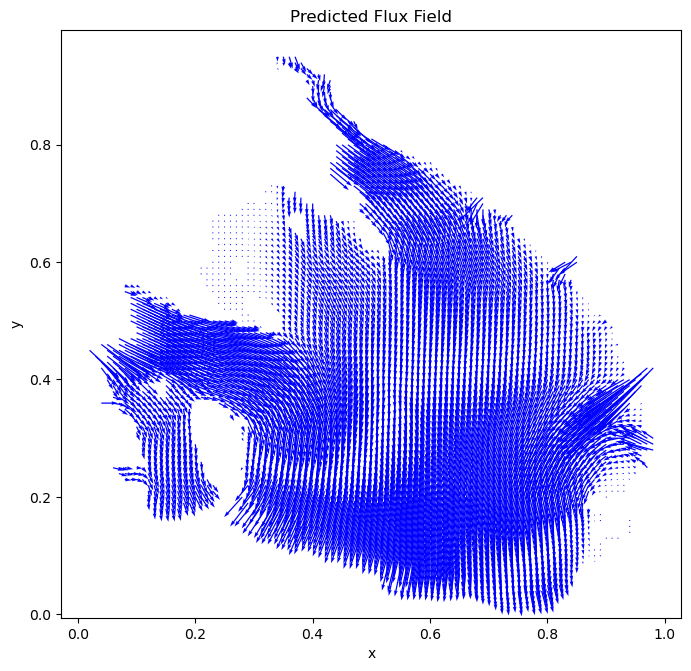

In [23]:
# Split into components
U = prediction[:, 0].cpu().detach().numpy()
V = prediction[:, 1].cpu().detach().numpy()

# Get grid coordinates back from your input X_grid_sub
X = X_grid_sub[:, 0].cpu().detach().numpy()
Y = X_grid_sub[:, 1].cpu().detach().numpy()

plt.figure(figsize = (8, 8))
plt.quiver(X, Y, U, V, scale = 50, width = 0.002, color = "blue")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Flux Field")
plt.gca().set_aspect("equal")
plt.show()

In [27]:
X_grid_sub[:, 0].shape

torch.Size([4531])

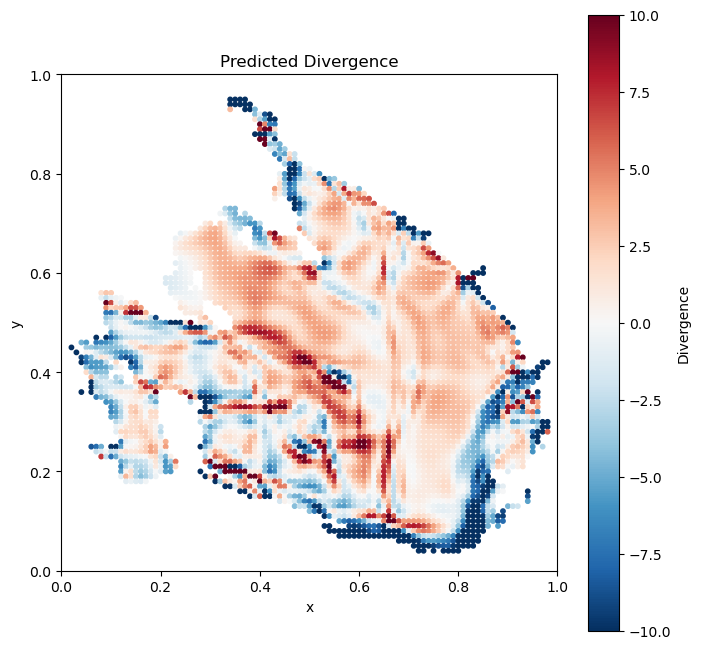

In [28]:
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

plt.figure(figsize = (8, 8))
plt.scatter(
    X_grid_sub[:, 0].cpu().detach().numpy(), 
    X_grid_sub[:, 1].cpu().detach().numpy(),
    c = div_field.cpu().detach().numpy(), 
    cmap = "RdBu_r", 
    vmin = - 10, vmax = 10,
    s = 10)
plt.colorbar(label = "Divergence")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Divergence")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.gca().set_aspect("equal")
plt.show()

# Downsample

In [29]:
prediction = model(X_grid_ds.requires_grad_(True))

div_field = compute_divergence_field(
    mean_pred = prediction, 
    x_grad = X_grid_ds)

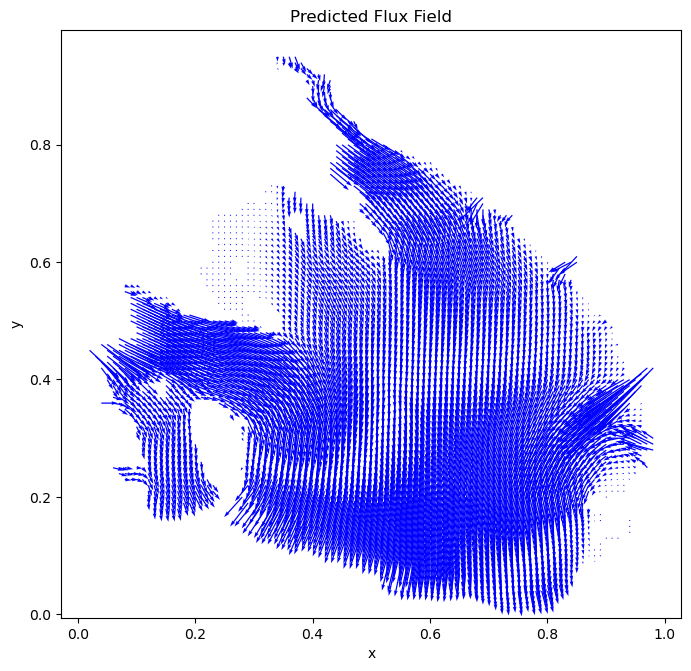

In [30]:
# Split into components
U = prediction[:, 0].cpu().detach().numpy()
V = prediction[:, 1].cpu().detach().numpy()

# Get grid coordinates back from your input X_grid_sub
X = X_grid_ds[:, 0].cpu().detach().numpy()
Y = X_grid_ds[:, 1].cpu().detach().numpy()

plt.figure(figsize = (8, 8))
plt.quiver(X, Y, U, V, scale = 50, width = 0.002, color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Flux Field")
plt.gca().set_aspect("equal")
plt.show()

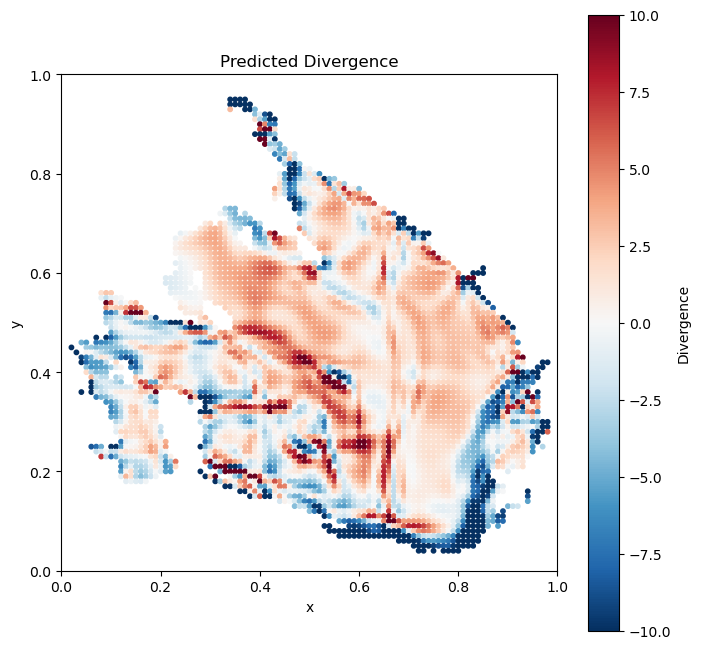

In [31]:
plt.figure(figsize = (8, 8))
plt.scatter(
    X_grid_ds[:, 0].cpu().detach().numpy(), 
    X_grid_ds[:, 1].cpu().detach().numpy(),
    c = div_field.cpu().detach().numpy(), 
    cmap = "RdBu_r", 
    vmin = - 10, vmax = 10,
    s = 10)
plt.colorbar(label = "Divergence")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Divergence")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.gca().set_aspect("equal")
plt.show()

# Divergence

- Positive divergence: Mass loss (thinning)   
- Negative divergence: Mass gain (accum)

# SMB

smb = acc - abl

- Positive smb: More accumulation than ablation
- Negative smb: More ablation than ablation

Over Ross we have more snowfall.

# Equation

from Morlighem
- dH/dt + div (H * u) = M_s - M_b
    - M_b: basal melting rate (m/yr ice equivalent, positive when melting, negative when freezing)
    - M_s: surface mass balance (m/yr ice equivalent, positive for accumulation, negative for ablation)
    - ice flux divergence is balanced by the rate of thickness change and the net surface and basal mass balances.

Thus:

M_b = - div (H * u) + Ms

# Convert units back to physical units

- **dxy = 1_000_000** because the normalised range [0, 1] presents [0, 1_000_000 m] (1000 km range) in real life.
- **flux_scale = 100_000** because we devided fluxes by 100_000 to acheve ~ 1 std i.e. var of flux in both directions.
    - The mean ice thickness of 420 meters * 438 mean ice speed yields ice flux of 183_960 for example.
- To rescale the div_field to physical units we do **div_phys = div_field * flux_scale / dxy**
- This simplifies to **dividing by 10** to get **m / year** units.

In [32]:
dxy = 1_000_000
flux_scale = 100_000

div_phys = div_field * flux_scale / dxy

print("Divergence (model units):", div_field[0:3].tolist())
print("Divergence (meter per yr):", div_phys[0:3].tolist())

Divergence (model units): [-21.642147064208984, -33.71321487426758, -31.62460708618164]
Divergence (meter per yr): [-2.164214849472046, -3.371321439743042, -3.1624608039855957]


# Show divergence

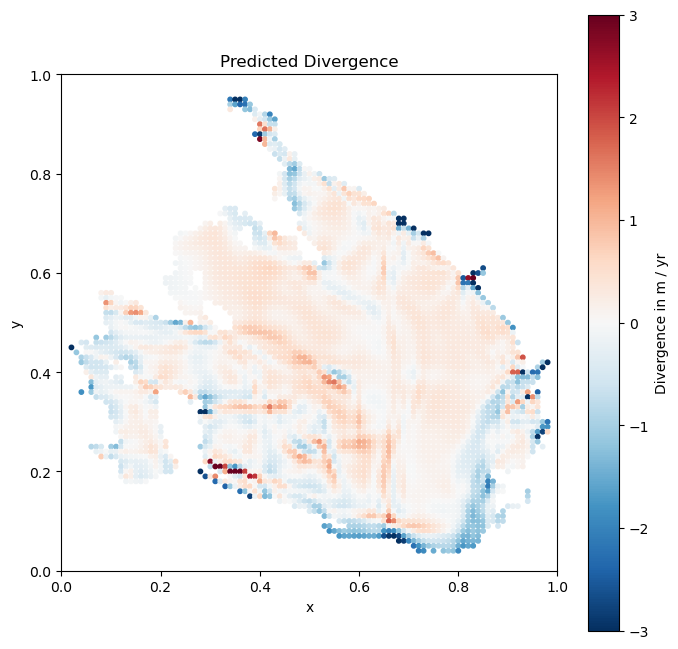

In [33]:
plt.figure(figsize = (8, 8))
plt.scatter(
    X_grid_ds[:, 0].cpu().detach().numpy(), 
    X_grid_ds[:, 1].cpu().detach().numpy(),
    c = div_field.cpu().detach().numpy() / 10, 
    # NOTE: Higher div: thinning
    cmap = "RdBu_r", 
    vmin = - 3, vmax = 3,
    s = 10)
plt.colorbar(label = "Divergence in m / yr")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Divergence")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.gca().set_aspect("equal")
plt.show()

# SMB

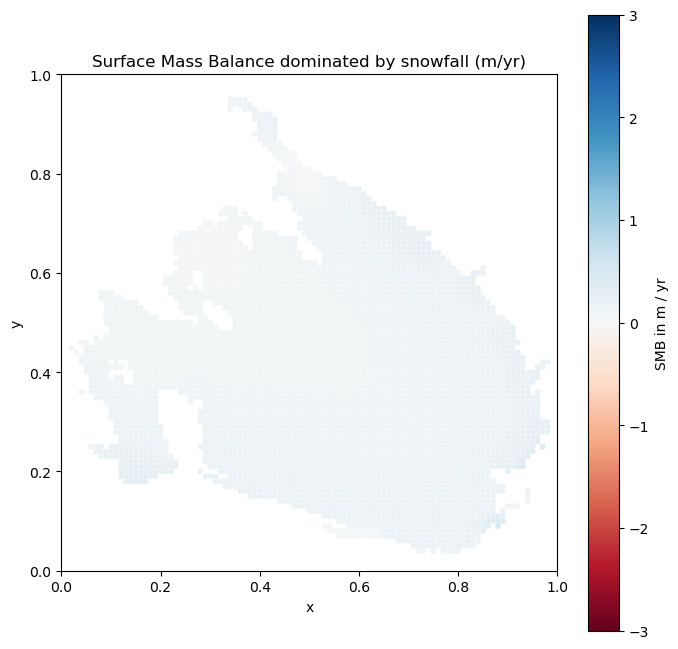

In [34]:
# Load data on grid
tensor_x_y_smb_m_yr = torch.load("data/smb_ross_ds_norm_m_per_yr.pt")

plt.figure(figsize = (8, 8))
plt.scatter(
    X_grid_ds[:, 0].cpu().detach().numpy(), 
    X_grid_ds[:, 1].cpu().detach().numpy(),
    c = np.array(tensor_x_y_smb_m_yr[:, -1]),
    # Gain: Blue
    cmap = "RdBu",
    # Show on fixed scale
    vmin = - 3, vmax = 3,
    s = 10)
plt.colorbar(label = "SMB in m / yr")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Surface Mass Balance dominated by snowfall (m/yr)")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)

plt.gca().set_aspect("equal")
plt.show()

# Basal melt (steady-state)

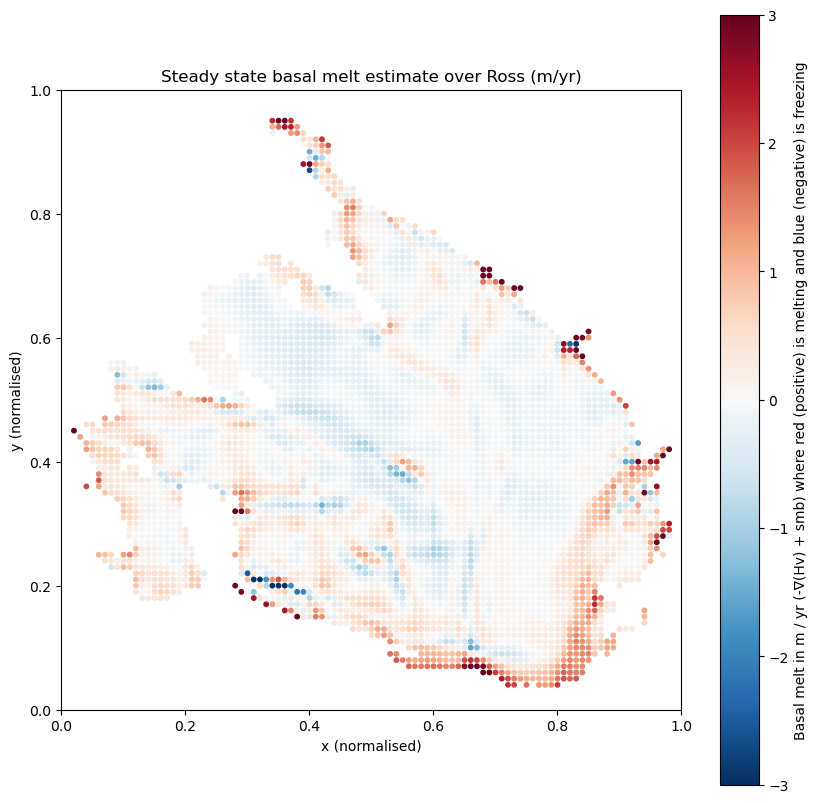

In [36]:
plt.figure(figsize = (10, 10))
plt.scatter(
    X_grid_ds[:, 0].cpu().detach().numpy(), 
    X_grid_ds[:, 1].cpu().detach().numpy(),
    # NOTE: BASAL MELT is MINUS DIV + SMB
    c = (- div_field.cpu().detach().numpy() / 10) + np.array(tensor_x_y_smb_m_yr[:, -1]),
    cmap = "RdBu_r",
    vmin = - 3, vmax = 3,
    s = 10)
plt.colorbar(label = "Basal melt in m / yr (-∇(Hv) + smb) where red (positive) is melting and blue (negative) is freezing")
plt.xlabel("x (normalised)")
plt.ylabel("y (normalised)")
plt.title("Steady state basal melt estimate over Ross (m/yr)")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.gca().set_aspect("equal")
plt.show()

# Basal melt map like Rignot

- 5 to 5 m scale


TypeError: Colorbar.__init__() got an unexpected keyword argument 'size'

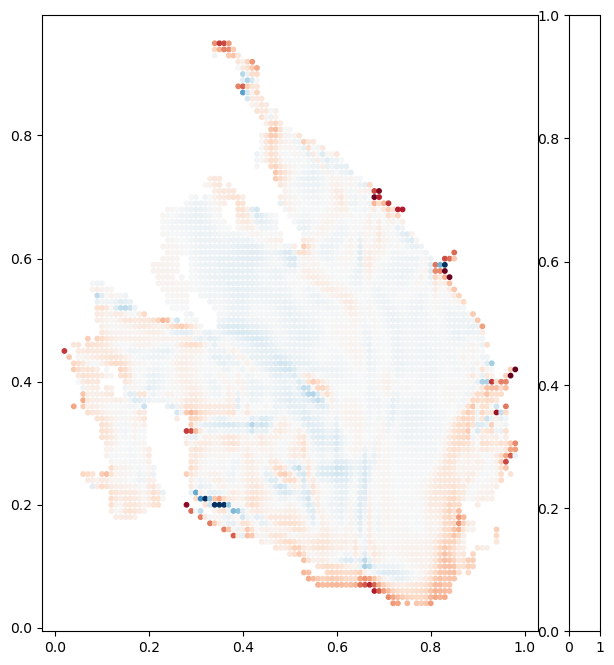

In [40]:
plt.figure(figsize = (8, 8))
plt.scatter(
    X_grid_ds[:, 0].cpu().detach().numpy(), 
    X_grid_ds[:, 1].cpu().detach().numpy(),
    # NOTE: BASAL MELT is MINUS DIV + SMB
    c = (- div_field.cpu().detach().numpy() / 10) + np.array(tensor_x_y_smb_m_yr[:, -1]),
    # melt should still be red
    cmap = "RdBu_r",
    vmin = - 5, vmax = 5,
    s = 10)
plt.colorbar(label = "Basal melt in m / yr (-∇(Hv) + smb)", size = 0.8)
plt.xlabel("x (normalised)")
plt.ylabel("y (normalised)")
plt.title("Steady state basal melt estimate over Ross (m/yr)")
plt.suptitle("Red (positive) is melting and blue (negative) is freezing")
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.gca().set_aspect("equal")
plt.show()

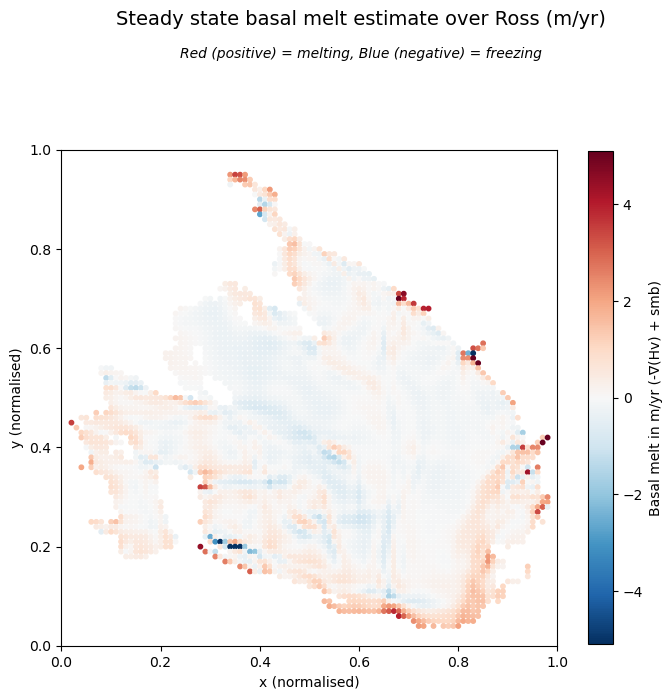

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

sc = ax.scatter(
    X_grid_ds[:, 0].cpu().detach().numpy(), 
    X_grid_ds[:, 1].cpu().detach().numpy(),
    c = (- div_field.cpu().detach().numpy() / 10) + np.array(tensor_x_y_smb_m_yr[:, -1]),
    cmap = "RdBu_r",
    vmin = -5.1, vmax = 5.1,
    s = 10
)

# shrink colorbar with shrink=
cbar = plt.colorbar(sc, ax=ax, label="Basal melt in m/yr (-∇(Hv) + smb)", shrink=0.8)

ax.set_xlabel("x (normalised)")
ax.set_ylabel("y (normalised)")

# main title
fig.suptitle("Steady state basal melt estimate over Ross (m/yr)", fontsize=14, y=0.98)

# subtitle (smaller font, below the title)
fig.text(0.5, 0.92, "Red (positive) = melting, Blue (negative) = freezing", 
         ha="center", fontsize=10, style="italic")

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")

# save the figure before showing
plt.savefig("basal_melt_ross.png", dpi=300, bbox_inches="tight")
plt.show()

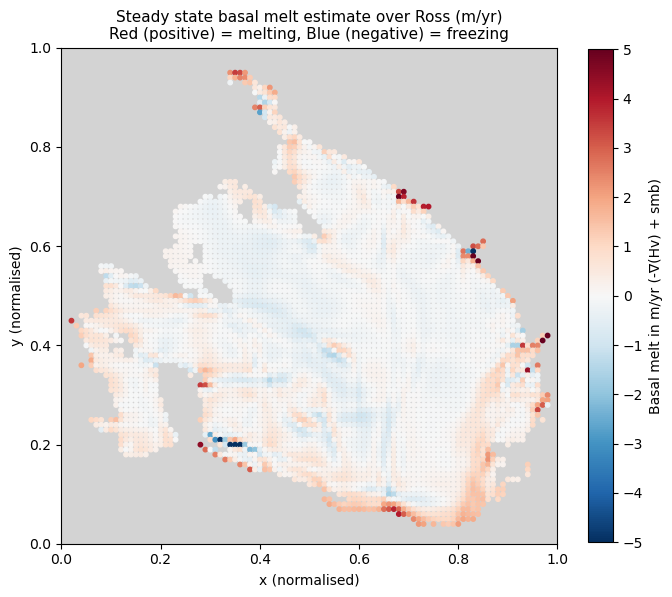

In [57]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_facecolor("lightgrey")

sc = ax.scatter(
    X_grid_ds[:, 0].cpu().detach().numpy(), 
    X_grid_ds[:, 1].cpu().detach().numpy(),
    c = (- div_field.cpu().detach().numpy() / 10) + np.array(tensor_x_y_smb_m_yr[:, -1]),
    cmap = "RdBu_r",
    vmin = -5.0, vmax = 5.0,
    s = 10
)

# shrink colorbar
cbar = plt.colorbar(sc, ax=ax, label="Basal melt in m/yr (-∇(Hv) + smb)", shrink = 0.8)
cbar.set_ticks([- 5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])   # make sure -5 and 5 appear

ax.set_xlabel("x (normalised)")
ax.set_ylabel("y (normalised)")

ax.set_title("Steady state basal melt estimate over Ross (m/yr)\n"
             "Red (positive) = melting, Blue (negative) = freezing",
             fontsize = 11)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect("equal")

plt.savefig("basal_melt_ross.png", dpi = 300, bbox_inches = "tight")
plt.show()

## Integrate dH/dt data

# Thickness map